In [1]:
# Importing necessary libraries
import pandas as pd
pd.options.display.max_rows = 1000

import numpy as np

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import Data
xls = pd.ExcelFile("StaticPricingDetails_2022_06_01_16_06_32.xlsx")
df = pd.read_excel(xls, sheet_name="Stock Days") # Our main table, containing Items' SKUs, Costs, Prices, etc.
SKU_sales = pd.read_excel(xls, sheet_name="US SKU Sales") # Items' Sales as Packages
Part_sales = pd.read_excel(xls, sheet_name="US Part Sales") # Items' Sales as Singles

Item_category = pd.read_excel("ItemcategoryResults.xlsx") # Items' Categories

<br/><br/>
### 0. Data Preparations ###

Table `df` is our main table, we should look into it and extract the follwoing valued information we could make use of:
- __SKU__: Product identity, each item should have an unique SKU;
- __ProductType__: _InventoryItem_ if this item is a single, _KitItem_ if it is a package;
- __OnHand__: Amount of SKU that is in stock;
- __HOT__: Hot Product;
- __US_ProductCost__: Item Cost in USD;
- __US_Price__: Item's sale price in USD.

In [3]:
print(df.columns)
# We don't need all the data in this table
df = df[["SKU", "ProductType", "OnHand", "HOT", "DOI", "US_ProductCost", "US_Price"]]
df['Profit'] = df["US_Price"] - df["US_ProductCost"]

Index(['SKU', 'ProductType', 'Available', 'HOT', 'DOI', 'eBaySalesForYear',
       'eBaySalesFor30D', 'eBayCompPriceUS', 'eBayCompPriceCA',
       'US_ProductCost', 'US_ShippingCost', 'CA_ProductCost',
       'CA_ShippingCost', 'US_Price', 'CA_Price', 'W1_Days', 'W2_Days',
       'W3_Days', 'W4_Days', 'M1_Days', 'M2_Days', 'M3_Days', 'M4_Days',
       'M5_Days', 'M6_Days', 'M7_Days', 'M8_Days', 'M9_Days', 'M10_Days',
       'M11_Days', 'M12_Days', 'M13_Days', 'M14_Days', 'M15_Days', 'M16_Days',
       'M17_Days', 'M18_Days', 'M19_Days', 'M20_Days', 'M21_Days', 'M22_Days',
       'M23_Days', 'M24_Days', 'M25_Days', 'M26_Days', 'OnHand'],
      dtype='object')


In [4]:
df.head()

,SKU,ProductType,OnHand,HOT,DOI,US_ProductCost,US_Price,Profit
0,AC1003,InventoryItem,62,64,298,92.62,120.60,27.98
1,AC1016,InventoryItem,45,45,210,89.73,156.63,66.90
2,AC1023,InventoryItem,63,63,882,97.24,137.21,39.97
3,ADSKARC8005,InventoryItem,276,338,246,26.74,55.77,29.03
4,ADSKARC8005PR,KitItem,138,169,246,53.48,93.35,39.87


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13005 entries, 0 to 13004
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SKU             13005 non-null  object 
 1   ProductType     13005 non-null  object 
 2   OnHand          13005 non-null  int64  
 3   HOT             13005 non-null  int64  
 4   DOI             13005 non-null  int64  
 5   US_ProductCost  13005 non-null  float64
 6   US_Price        13005 non-null  float64
 7   Profit          13005 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 812.9+ KB


In [6]:
df.shape

(13005, 8)

In [9]:
df['SKU'].nunique() # See if there exists duplications

13005

<br/><br/>
Organize the Sales tables. Extract the sales data in three different lengths of period: __Monthly_Sales__, __90_Day_Sales__, and __Yearly_Sales__.

In [10]:
SKU_sales['Monthly_Sales'] = SKU_sales['M1_Qty']
SKU_sales['90_Day_Sales'] = SKU_sales['M1_Qty'] + SKU_sales['M2_Qty'] + SKU_sales['M3_Qty']
SKU_sales['Yearly_Sales'] = SKU_sales.iloc[:,6:18].sum(axis=1)
SKU_sales = SKU_sales[['SKU', 'Monthly_Sales', '90_Day_Sales', 'Yearly_Sales']]

Part_sales['Monthly_Sales'] = Part_sales['M1_Qty']
Part_sales['90_Day_Sales'] = Part_sales['M1_Qty'] + Part_sales['M2_Qty'] + Part_sales['M3_Qty']
Part_sales['Yearly_Sales'] = Part_sales.iloc[:,5:17].sum(axis=1)
Part_sales = Part_sales[['SKU', 'Monthly_Sales', '90_Day_Sales', 'Yearly_Sales']]

In [11]:
SKU_sales.describe()

,Monthly_Sales,90_Day_Sales,Yearly_Sales
count,13005.000000,13005.000000,13005.000000
mean,5.568551,16.473895,50.586544
std,11.832277,36.131678,105.455683
min,0.000000,0.000000,0.000000
25%,0.000000,1.000000,4.000000
50%,2.000000,5.000000,18.000000
75%,6.000000,18.000000,56.000000
max,323.000000,1271.000000,4256.000000


In [12]:
Part_sales.describe()

,Monthly_Sales,90_Day_Sales,Yearly_Sales
count,5391.000000,5391.000000,5391.000000
mean,28.076238,80.923576,243.140976
std,46.481416,131.536191,336.435069
min,0.000000,0.000000,0.000000
25%,4.000000,17.000000,66.000000
50%,14.000000,43.000000,150.000000
75%,33.000000,93.500000,294.000000
max,712.000000,2192.000000,4957.000000


<br/><br/>
We can now start combining the sales data to the main table by each item's __ProductType__.
Along this process, we will create two tables: `df_inventory` and `df_kit`, which store only the data of singles and packages respectively.

In [13]:
df_inventory = df[df['ProductType']=='InventoryItem']
df_inventory = pd.merge(df_inventory, Part_sales, on='SKU', how='left')

df_kit = df[df['ProductType']=='KitItem']
df_kit = pd.merge(df_kit, SKU_sales, on='SKU', how='left')

<br/><br/>
We will also have a main table that stores data for all SKUs, we call this table `result`:

In [14]:
result = pd.concat([df_inventory, df_kit]).sort_values('SKU').reset_index(drop=True)
result.head(10)

,SKU,ProductType,OnHand,HOT,DOI,US_ProductCost,US_Price,Profit,Monthly_Sales,90_Day_Sales,Yearly_Sales
0,AC1003,InventoryItem,62,64,298,92.62,120.60,27.98,6,16,38
1,AC1016,InventoryItem,45,45,210,89.73,156.63,66.90,6,14,71
2,AC1023,InventoryItem,63,63,882,97.24,137.21,39.97,5,19,66
3,ADSKARC8005,InventoryItem,276,338,246,26.74,55.77,29.03,33,110,315
4,ADSKARC8005PR,KitItem,138,169,246,53.48,93.35,39.87,6,23,73
5,ADSKARC8008,InventoryItem,55,140,156,27.73,59.48,31.75,15,58,144
6,ADSKARC8008PR,KitItem,55,140,142,55.39,100.81,45.42,6,29,69
7,ADSKARC8018,InventoryItem,60,145,142,27.66,60.66,33.00,16,61,140
8,ADSKARC8020,InventoryItem,87,87,87,30.68,64.74,34.06,20,51,105
9,ADSKARC8020PR,KitItem,43,43,87,61.36,120.91,59.55,7,19,42


In [15]:
result.isnull().sum()

SKU               0
ProductType       0
OnHand            0
HOT               0
DOI               0
US_ProductCost    0
US_Price          0
Profit            0
Monthly_Sales     0
90_Day_Sales      0
Yearly_Sales      0
dtype: int64

In [16]:
result.shape

(13005, 11)

<br/><br/>
Now, we can start adding item categories for all the single items by merging it to the table `Item_category`

In [17]:
Item_category = Item_category[['Name', 'Wms Category']]
Item_category.dropna(subset=['Wms Category'], inplace=True)
df_inventory = pd.merge(df_inventory, Item_category, how='left', left_on='SKU', right_on='Name')
df_inventory.drop(columns=['Name'], inplace=True)
df_inventory.head(10)

,SKU,ProductType,OnHand,HOT,DOI,US_ProductCost,US_Price,Profit,Monthly_Sales,90_Day_Sales,Yearly_Sales,Wms Category
0,AC1003,InventoryItem,62,64,298,92.62,120.60,27.98,6,16,38,Air Suspension Compressor
1,AC1016,InventoryItem,45,45,210,89.73,156.63,66.90,6,14,71,Air Suspension Compressor
2,AC1023,InventoryItem,63,63,882,97.24,137.21,39.97,5,19,66,Air Suspension Compressor
3,ADSKARC8005,InventoryItem,276,338,246,26.74,55.77,29.03,33,110,315,ATV Axles
4,ADSKARC8008,InventoryItem,55,140,156,27.73,59.48,31.75,15,58,144,ATV Axles
5,ADSKARC8018,InventoryItem,60,145,142,27.66,60.66,33.00,16,61,140,ATV Axles
6,ADSKARC8020,InventoryItem,87,87,87,30.68,64.74,34.06,20,51,105,ATV Axles
7,ADSKARC8030,InventoryItem,63,63,441,29.50,60.58,31.08,3,14,69,ATV Axles
8,ADSKCA9325,InventoryItem,23,23,2300,28.66,46.85,18.19,4,20,44,ATV Axles
9,ADSKCA9326,InventoryItem,20,20,280,28.46,59.37,30.91,5,22,47,ATV Axles


<br/><br/>
### 1. Study of Profit ###
_Part I_: <br/>
We want to see the profit distributions of the categories that at least have significant amounts of SKUs. Let's look at the statistic info for __Profit__ in the table `df_inventory` and the numbers of SKUs for all categories.

In [18]:
df_inventory['Profit'].describe()

count    5391.000000
mean       32.537149
std        16.477904
min       -10.230000
25%        20.850000
50%        31.880000
75%        40.305000
max       189.230000
Name: Profit, dtype: float64

In [19]:
df_inventory['Wms Category'].value_counts()

Brake Calipers New                      820
Complete Struts                         514
Control Arms                            438
Performance Rotors                      396
Brake Rotors                            350
Radiators                               349
Performance Rotors Silver               300
Brake Pads Ceramic                      298
Shocks                                  230
HUB ASSY DOUBLE FLANGE BALL BEARINGS    227
Axle Shafts                             152
Struts                                  119
Brake Pads                              110
Steering Knuckle - Loaded               108
Performance Ceramic Brake Pads          105
Mirrors                                 100
Window Regulators                        98
Mirrors - Trucks                         96
Catalytic Converters                     72
ATV Axles                                67
Steering Knuckle                         57
Drive Shaft                              54
Exhausts - Converters           

<br/><br/>
We only want to see the profit distributions for the categories that have equal or more than 50 SKUs.

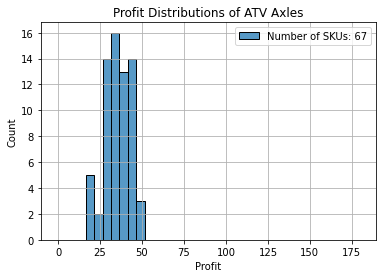

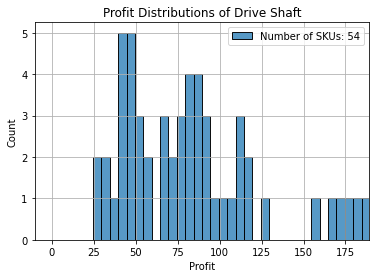

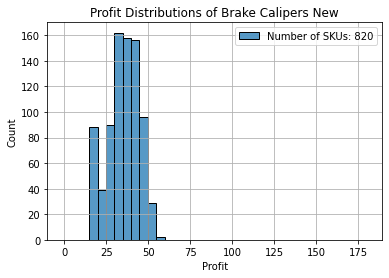

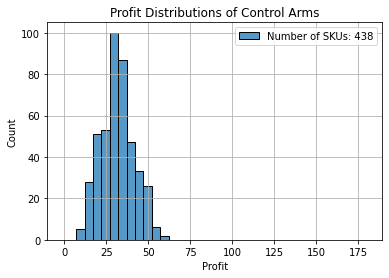

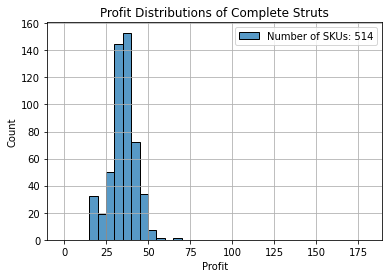

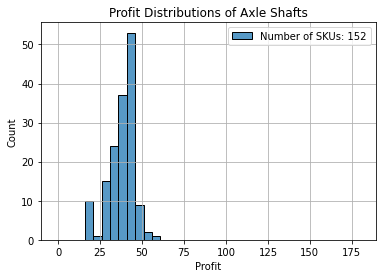

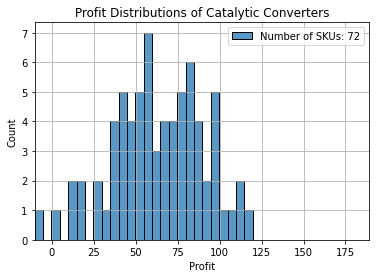

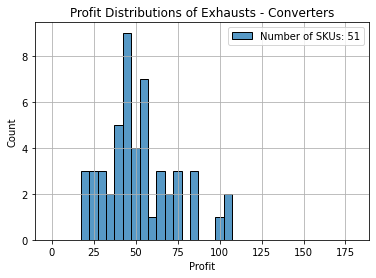

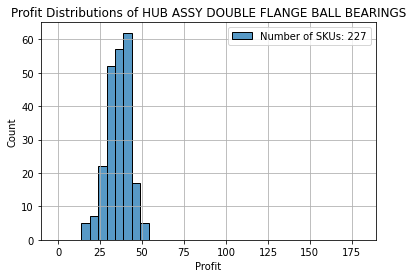

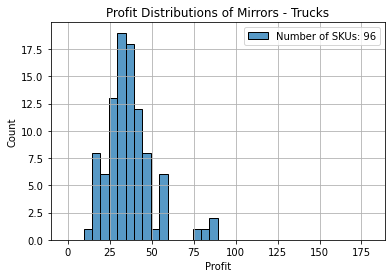

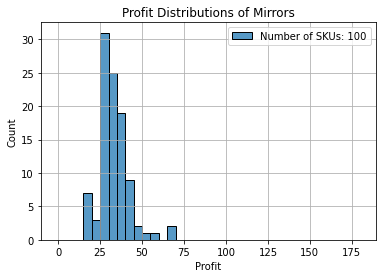

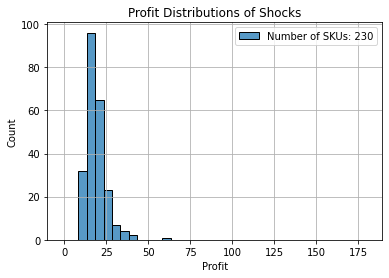

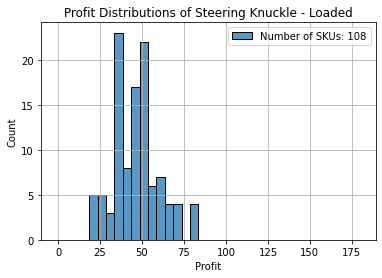

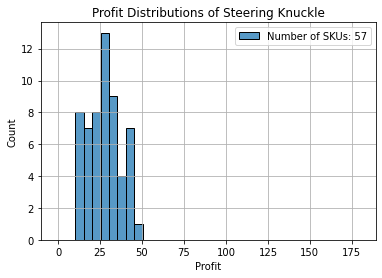

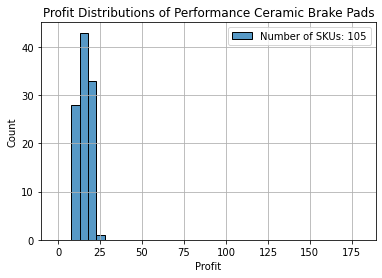

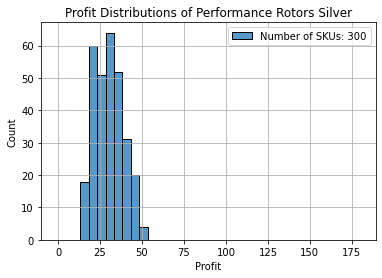

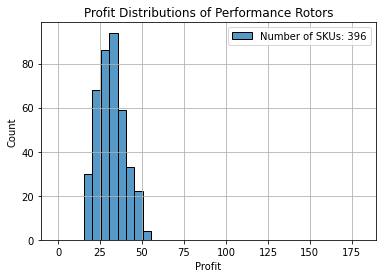

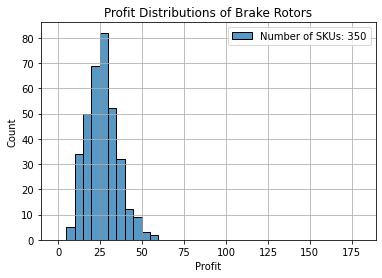

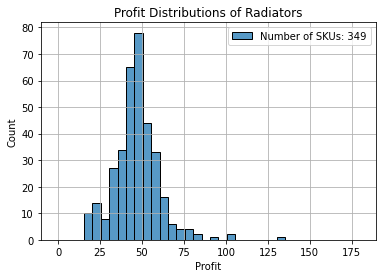

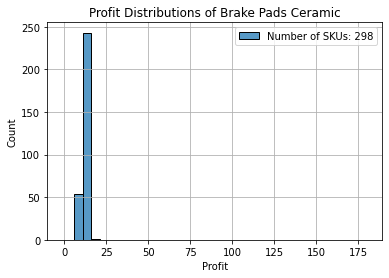

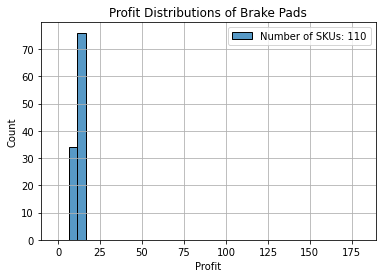

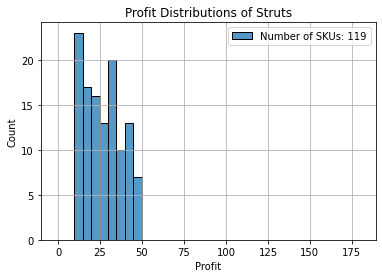

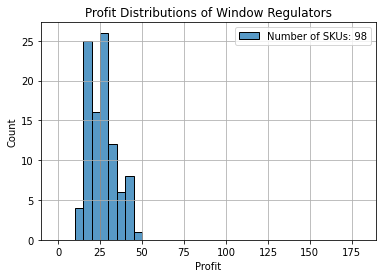

In [122]:
high_categories = []
for i in df_inventory['Wms Category'].unique():
    s = df_inventory[df_inventory['Wms Category']==i]
    if len(s)>=50:
        high_categories.append(i)
        sns.histplot(s['Profit'], binwidth=5, label="Number of SKUs: {}".format(len(s)))
        plt.xlim(min(df_inventory['Profit']),max(df_inventory['Profit']))
        plt.title("Profit Distributions of " + i)
        plt.legend()
        plt.grid()
        plt.show()

In [172]:
print("We have {} categories that have equal or more than 50 SKUs.".format(len(high_categories)))

We have 23 categories that have equal or more than 50 SKUs.


<br/><br/>
From the histograms above, we acan tell:
- The profits of most SKUs in all categories are mainly between \\$25 and \\$50.    
- Some _Drive Shafts_ can profit more than \\$50, even moren than \\$175.
- There exists a few products of _Catalytic Converters_ profit low, even less than \\$0.

<br/><br/>
_Part II_: <br/>
Let's look at the profit distributions for all categories in one graph, sorting categories from the highest in the profit average to the lowest. We will be using a plot called ___boxplot___.

<blockquote>
<img src="boxplot_elements.png" alt="boxplot" width="600"/>

`Boxplots are a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).`

- __Median (Q2/50th Percentile)__: the middle value of the dataset.

- __First Quartile (Q1/25th Percentile)__: the middle number between the smallest number (not the “minimum”) and the median of the dataset.

- __Third Quartile (Q3/75th Percentile)__: the middle value between the median and the highest value (not the “maximum”) of the dataset.

- __Interquartile Range (IQR)__: 25th to the 75th percentile.

- __Whiskers (shown in blue)__

- __Outliers (shown as green circles)__

- __“Maximum”__: Q3 + 1.5*IQR

- __“Minimum”__: Q1 -1.5*IQR
</blockquote>

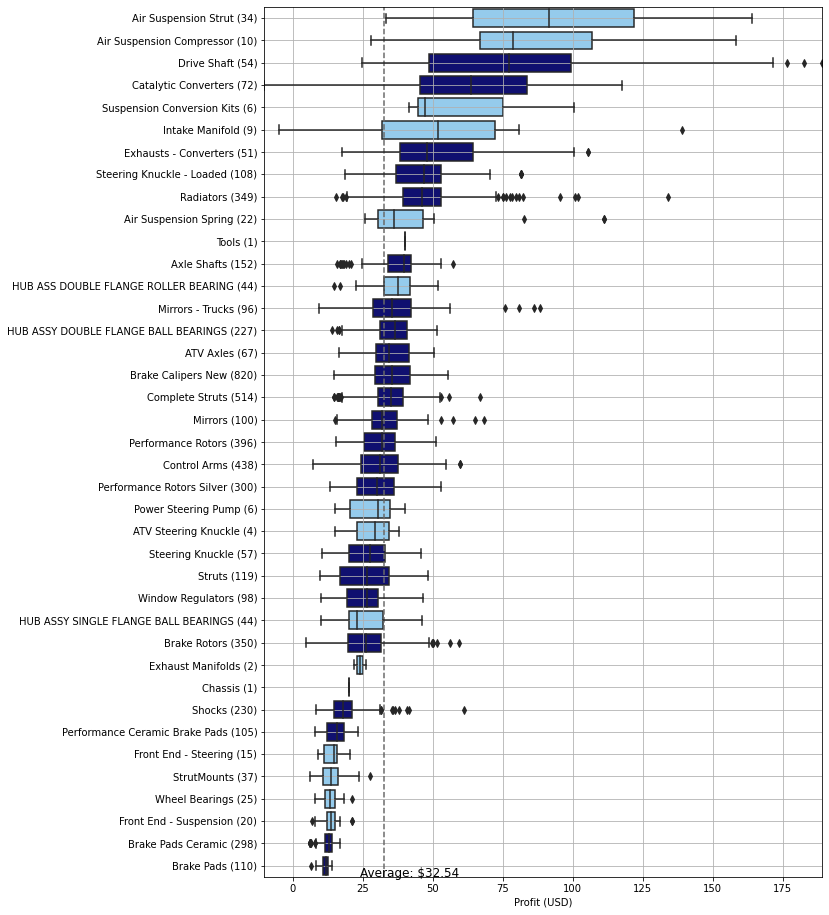

In [169]:
plt.figure(figsize=(10,16))


# Plot the profit distribution using boxenplot
s = df_inventory.pivot(columns='Wms Category', values='Profit')
s_index = s.mean().sort_values(ascending=False).index
s_sort = s[s_index]

hot_cat = {category: "navy" if category in high_categories else "lightskyblue" for category in df_inventory['Wms Category'].unique()}
ax = sns.boxplot(data=s_sort, orient="h", palette=hot_cat)


# Add a average reference
average_profit = df_inventory['Profit'].mean()
ax.vlines(average_profit, 0, 1, transform=ax.get_xaxis_transform(), colors='dimgray').set_linestyle("--")
ax.text(average_profit/max(df_inventory['Profit']), 0, 
        "Average: ${}".format(round(average_profit,2)), 
        transform=ax.transAxes, 
        weight=500, size=12, ha='left')


# Setting the y_tick label to also display the number of samples in each category
ytick = []
for i in s_sort.columns:
    ytick.append(i + " (" + str(len(df_inventory[df_inventory['Wms Category']==i])) + ")")
ax.set_yticklabels(ytick)


ax.set(ylabel=None, xlabel="Profit (USD)")
plt.xlim(min(df_inventory['Profit']),max(df_inventory['Profit']))
plt.grid()


<br/><br/>
_Part III_: <br/>
The next aspect is to study the sales amount, before we start, we want to learn if there is a relationship between __Sales Amount__ and __Profit__, we can then use a `bubble chart` to display.

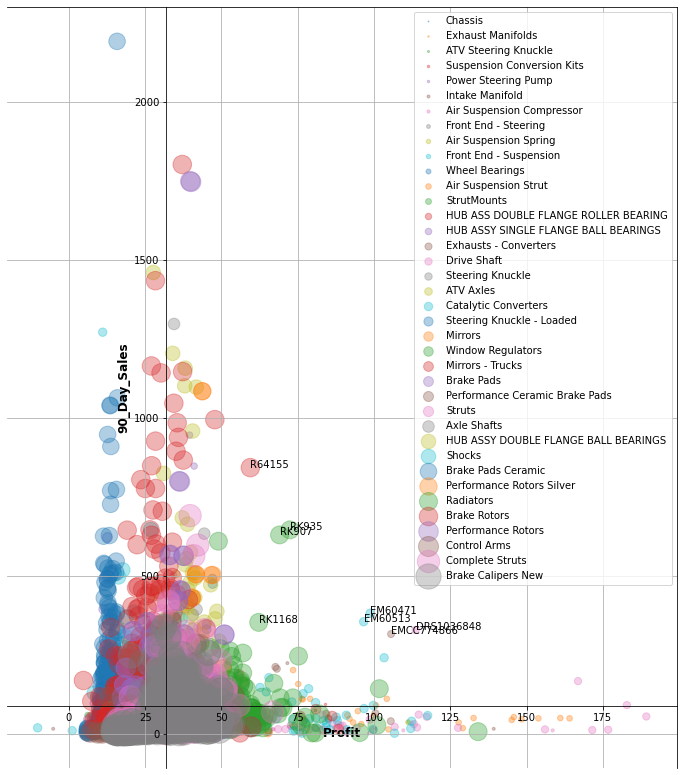

In [298]:
s = df_inventory[['SKU', 'Profit', '90_Day_Sales', 'Wms Category']][df_inventory['90_Day_Sales'] > 0]
s['Counts'] = s.groupby(['Wms Category'])['Wms Category'].transform('count')
s.sort_values('Counts', inplace=True)


plt.figure(figsize=(12,14))
for i in s['Wms Category'].unique():
    plt.scatter(data=s[s['Wms Category']==i], x='Profit', y='90_Day_Sales', s='Counts', alpha=0.35, label=i)

    
# Labeling the SKUs with good Profit and 90 day Sales Amount
labels = s[(s['Profit']>s['Profit'].quantile(0.95)) & (s['90_Day_Sales']>s['90_Day_Sales'].quantile(0.95))]
for i in range(len(labels)):
    plt.text(x=labels['Profit'].iloc[i], y=labels['90_Day_Sales'].iloc[i], s=labels['SKU'].iloc[i])


# Moving the X_axis and Y_axis to the mean positions
plt.axes().spines['bottom'].set_position(('data', s['90_Day_Sales'].mean()))
plt.axes().spines['left'].set_position(('data', s['Profit'].mean()))
plt.xlabel('Profit', weight=800, size=12)
plt.ylabel('90_Day_Sales', weight=800, size=12)


plt.legend(bbox_to_anchor =(1, 1))
plt.grid()
plt.show()

<br/><br/>
### 2. Study of Sales Amount ###

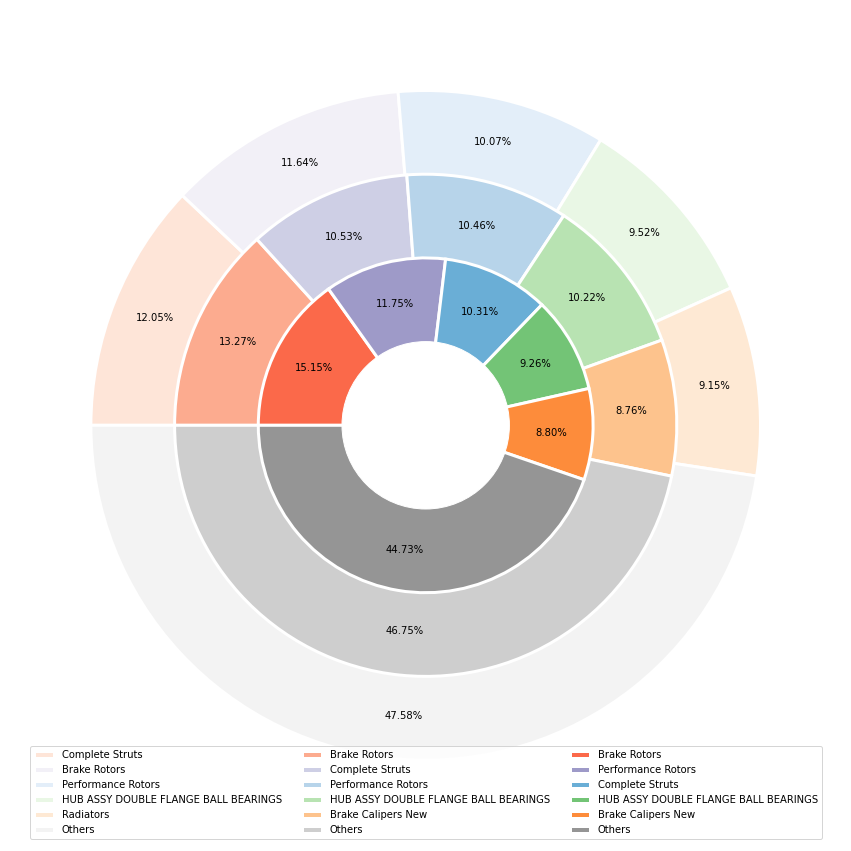

In [183]:
result_inventory = result[result['ProductType']=='InventoryItem']
result_inventory = pd.merge(result_inventory, Item_category, how='left', left_on='SKU', right_on='Name')

plt.figure(figsize=(15,18))

rad = [0.5, 0.75, 1]
pct_loc = [0.75, 0.82, 0.87]
fading = [0,0.2,0.4] 

cmap1 = plt.cm.Reds
cmap2 = plt.cm.Purples
cmap3 = plt.cm.Blues
cmap4 = plt.cm.Greens
cmap5 = plt.cm.Oranges
cmap6 = plt.cm.Greys
legend_to_show = []

for i in range(10,7,-1):
    result_inventory['PeriodProfit'] = result_inventory[result_inventory.columns[i]] * result_inventory['Profit']
    category_periodprofit = result_inventory.groupby('Wms Category')['PeriodProfit'].sum().reset_index(name ='Total Profit')
    category_periodprofit.sort_values('Total Profit', ascending=False, inplace=True)
    
    df = category_periodprofit[:5].copy()
    new_row = pd.DataFrame(data = {'Wms Category':['Others'], 'Total Profit':[category_periodprofit['Total Profit'][5:].sum()]})
    category_periodprofit = pd.concat([df, new_row])
    
    
    plt.pie(category_periodprofit['Total Profit'], 
            radius = rad[i-8], colors = [cmap1(.5-fading[i-8]), cmap2(.5-fading[i-8]), cmap3(.5-fading[i-8]), cmap4(.5-fading[i-8]), cmap5(.5-fading[i-8]), cmap6(.5-fading[i-8])],
            startangle=180, autopct='%1.2f%%', pctdistance=pct_loc[i-8],
            wedgeprops={'linewidth':3, 'edgecolor':'white'},
            labels=[" "]*6, labeldistance=0, 
            counterclock=False)
    
    legend_to_show.extend(category_periodprofit['Wms Category'].tolist())

my_circle=plt.Circle((0,0), 0.25, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.legend(legend_to_show, ncol=3, loc=8, fontsize=10)
#plt.title("Sales Percentages of Top 5 Categories", fontsize=12)
plt.show()




In [218]:
result_inventory.head(10)

,SKU,ProductType,OnHand,HOT,DOI,US_ProductCost,US_Price,Profit,Monthly_Sales,90_Day_Sales,Yearly_Sales,Name,Wms Category,PeriodProfit
0,AC1003,InventoryItem,62,64,298,92.62,120.60,27.98,6,16,38,AC1003,Air Suspension Compressor,167.88
1,AC1016,InventoryItem,45,45,210,89.73,156.63,66.90,6,14,71,AC1016,Air Suspension Compressor,401.40
2,AC1023,InventoryItem,63,63,882,97.24,137.21,39.97,5,19,66,AC1023,Air Suspension Compressor,199.85
3,ADSKARC8005,InventoryItem,276,338,246,26.74,55.77,29.03,33,110,315,ADSKARC8005,ATV Axles,957.99
4,ADSKARC8008,InventoryItem,55,140,156,27.73,59.48,31.75,15,58,144,ADSKARC8008,ATV Axles,476.25
5,ADSKARC8018,InventoryItem,60,145,142,27.66,60.66,33.00,16,61,140,ADSKARC8018,ATV Axles,528.00
6,ADSKARC8020,InventoryItem,87,87,87,30.68,64.74,34.06,20,51,105,ADSKARC8020,ATV Axles,681.20
7,ADSKARC8030,InventoryItem,63,63,441,29.50,60.58,31.08,3,14,69,ADSKARC8030,ATV Axles,93.24
8,ADSKCA9325,InventoryItem,23,23,2300,28.66,46.85,18.19,4,20,44,ADSKCA9325,ATV Axles,72.76
9,ADSKCA9326,InventoryItem,20,20,280,28.46,59.37,30.91,5,22,47,ADSKCA9326,ATV Axles,154.55


In [233]:
inventory_sales = result_inventory.groupby('Wms Category').agg({'Monthly_Sales':'sum',
                                                                '90_Day_Sales':'sum',
                                                                'Yearly_Sales':'sum'}).sort_values('Monthly_Sales',ascending=False).reset_index()
inventory_sales.head(5)

,Wms Category,Monthly_Sales,90_Day_Sales,Yearly_Sales
0,Brake Rotors,24935,64899,173551
1,Brake Pads Ceramic,17522,45970,120930
2,Performance Rotors,16950,44931,127996
3,Complete Struts,13596,40713,143323
4,HUB ASSY DOUBLE FLANGE BALL BEARINGS,12048,38953,110959


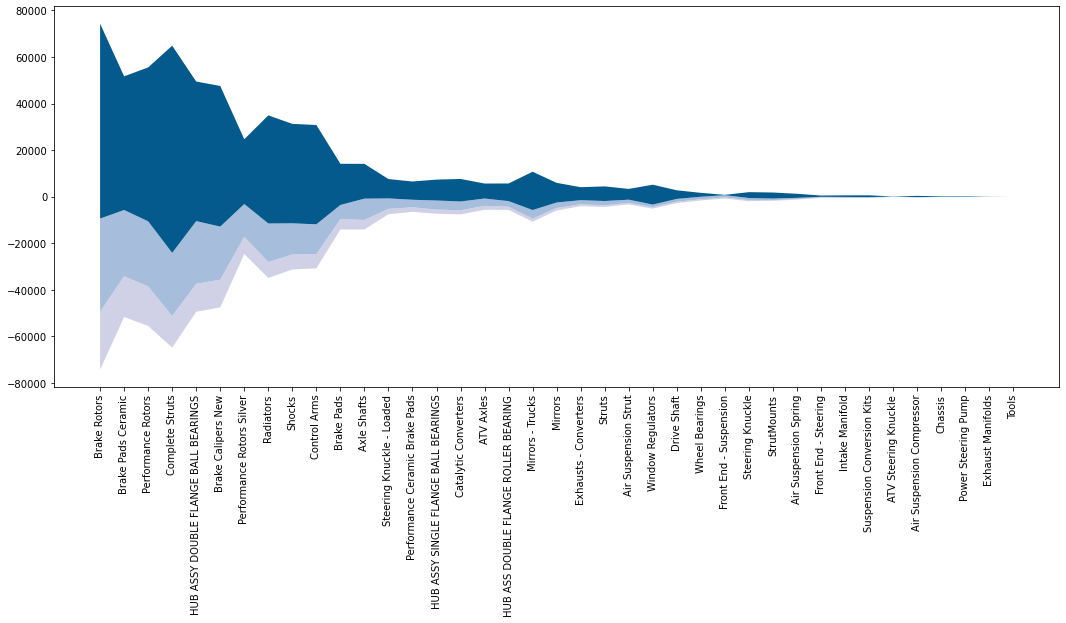

In [252]:

COLORS = ["#D0D1E6", "#A6BDDB", "#045A8D"]
fig, ax = plt.subplots(figsize=(18, 7))
ax.stackplot( inventory_sales['Wms Category'],  [inventory_sales['Monthly_Sales'], 
                                                 inventory_sales['90_Day_Sales']-inventory_sales['Monthly_Sales'], 
                                                 inventory_sales['Yearly_Sales']-inventory_sales['90_Day_Sales']-inventory_sales['Monthly_Sales']], 
            baseline='sym', colors=COLORS)

plt.xticks(rotation=90)
plt.show()